<a href="https://colab.research.google.com/github/tnichlani/Deep_Learning/blob/main/pothole_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Connect Kaggle to Drive

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab/Kaggle"

In [3]:
%cd /content/drive/MyDrive/Colab/Kaggle

/content/drive/MyDrive/Colab/Kaggle


In [4]:
!kaggle datasets download -d atulyakumar98/pothole-detection-dataset

100% 194M/194M [00:04<00:00, 53.2MB/s]



In [5]:
!ls

kaggle.json  normal			    potholes  templates
model.h5     pothole-detection-dataset.zip  static    test.jpeg


In [6]:
# unzip and delete zip files 
!unzip \*.zip && rm *.zip

Archive:  pothole-detection-dataset.zip
replace normal/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: normal/1.jpg            
  inflating: normal/10.jpg           
  inflating: normal/100.jpg          
  inflating: normal/101.jpg          
  inflating: normal/102.jpg          
  inflating: normal/103.jpg          
  inflating: normal/104.jpg          
  inflating: normal/105.jpg          
  inflating: normal/106.jpg          
  inflating: normal/107.jpg          
  inflating: normal/108.jpg          
  inflating: normal/109.jpg          
  inflating: normal/11.jpg           
  inflating: normal/110.jpg          
  inflating: normal/111.jpg          
  inflating: normal/112.jpg          
  inflating: normal/113.jpg          
  inflating: normal/114.jpg          
  inflating: normal/115.jpg          
  inflating: normal/116.jpg          
  inflating: normal/117.jpg          
  inflating: normal/118.jpg          
  inflating: normal/119.jpg          
  inflating: normal/12.j

Import Packages

In [7]:
# import packages 
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import cv2
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

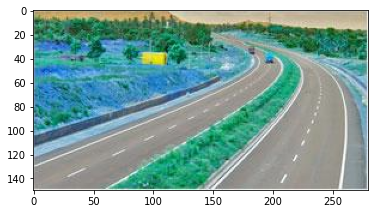

In [8]:
# show normal image
plt.imshow(cv2.imread('/content/drive/MyDrive/Colab/Kaggle/normal/1.jpg'))

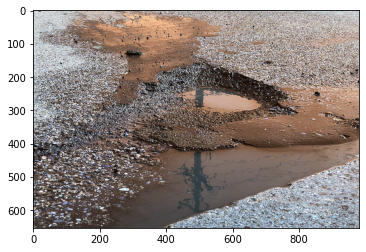

In [9]:
# show pothole image 
plt.imshow(cv2.imread('/content/drive/MyDrive/Colab/Kaggle/potholes/1.jpg'))

In [10]:
# initialize hyperparameters
BS = 25
EPOCHS = 10

Data Preprocessing

In [11]:
# train data generator
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    validation_split=0.2,
)

# train from directory
train_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab/Kaggle',
    target_size=(64, 64),
    batch_size=BS,
    class_mode='binary',
    subset='training'
)

Found 546 images belonging to 5 classes.


In [12]:
# val generator
# val from directory
val_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab/Kaggle',
    target_size=(64, 64),
    batch_size=BS,
    class_mode='binary',
    subset='validation'
)

Found 135 images belonging to 5 classes.


### **CNN**

In [13]:
# create CNN Model 
cnn = models.Sequential()
# conv 1
cnn.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)))
# pooling
cnn.add(layers.MaxPooling2D(pool_size=2, strides=2))
# conv 2
cnn.add(layers.Conv2D(32, (3,3), activation='relu'))
# pooling 2
cnn.add(layers.MaxPooling2D((2,2), strides=2))
# flatten 
cnn.add(layers.Flatten())
# fully connected 
cnn.add(layers.Dense(units=32, activation='relu'))
# output layer 
cnn.add(layers.Dense(units=1, activation='sigmoid'))

In [14]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                200736    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [19]:
# compile the model 
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = cnn.fit(x = train_set, validation_data = val_set, epochs = EPOCHS, verbose = 2)

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
def classify(img_path):
  plt.imshow(cv2.imread(img_path))
  test_image = image.load_img(img_path, target_size = (64, 64))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  result = cnn.predict(test_image)
  train_set.class_indices
  if result[0][0] == 1:
    prediction = 'pothole'
  else:
    prediction = 'normal'
  print(prediction)

In [ ]:
classify('/content/drive/MyDrive/Colab/Kaggle/test.jpeg')

### **VGG Net**

In [21]:
vgg = VGG16(input_shape=(64, 64, 3), weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
pred = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=vgg.input, outputs=pred)

model2.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [ ]:
#compile the model 
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#fit the model
history2 = model2.fit(x = train_set, validation_data = val_set, epochs = EPOCHS, verbose = 2)

In [ ]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
# save model to load later 
model2.save('model.h5')
print('Model Saved!')

Deploy on local machine

In [ ]:
!pip install flask-ngrok

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!mkdir static

In [ ]:
cd static

In [ ]:
!mkdir images

In [ ]:
import flask
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
import os

from tensorflow.keras.models import load_model 
from tensorflow.keras.preprocessing import image

In [ ]:
app = Flask(__name__)

image_folder = os.path.join('static', 'images')
app.config["UPLOAD_FOLDER"] = image_folder

export_dir='model.h5'

model_tf = tf.lite.TFLiteConverter.from_keras_model(export_dir)
model_tf

In [ ]:
@app.route('/', methods=['GET'])
def home():
  return render_template('index.html')

In [ ]:
@app.route('/', methods=['POST'])
def predict():
  # predicting images
  imagefile = request.files['imagefile']
  image_path = './static/images/' + imagefile.filename 
  imagefile.save(image_path)

  img = image.load_img(image_path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  pic = os.path.join(app.config['UPLOAD_FOLDER'], imagefile.filename)
  
  if classes[0]>0.5:
    return render_template('index.html', user_image=pic, prediction_text='{} No Potholes! :)'.format(imagefile.filename))
  else:
    return render_template('index.html', user_image=pic, prediction_text='{} Potholes! :('.format(imagefile.filename))

In [ ]:
if __name__=='__main__':
  app.run(port=5000, host='0.0.0.0')